In [ ]:
# import gymnasium
# from gymnasium.envs.registration import register
# register(
#     id='LinearFirstOrder-v0',
#     entry_point='my_gym_environments.envs:LinearFirstOrderEnv',
#     # max_episode_steps=300,

# )
# register(
#     id='LinearSecondOrder-v0',
#     entry_point='my_gym_environments.envs:LinearSecondOrderEnv',
#     # max_episode_steps=300,

# )
# register(
#     id='MyPendulum-v0',
#     entry_point='my_gym_environments.envs:MyPendulumEnv',
#     # max_episode_steps=300,

# )

In [ ]:
import numpy as np

class OUNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, action_scale, action_add):
        super(Actor, self).__init__()
        self.action_scale = torch.FloatTensor(action_scale).to(device)
        self.action_add = torch.FloatTensor(action_add).to(device)

        self.l1 = nn.Linear(state_dim, 16)
        self.l2 = nn.Linear(16, 32)
        self.l3 = nn.Linear(32, 16)
        self.l4 = nn.Linear(16, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = self.l4(a)
        # a = self.action_scale * (torch.tanh(a) + self.action_add)
        a = self.action_scale * torch.tanh(a) + self.action_add
        a = a*self.max_action

        return a

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 16)
        self.l2 = nn.Linear(16, 32)
        self.l3 = nn.Linear(32, 16)
        self.l4 = nn.Linear(16, 1)

        # Q2 architecture
        self.l5 = nn.Linear(state_dim + action_dim, 16)
        self.l6 = nn.Linear(16, 32)
        self.l7 = nn.Linear(32, 16)
        self.l8 = nn.Linear(16, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        # print(sa.shape)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)

        q2 = F.relu(self.l5(sa))
        q2 = F.relu(self.l6(q2))
        q2 = F.relu(self.l7(q2))
        q2 = self.l8(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)
        return q1

class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        action_scale, action_add,
        discount=0.99,
        tau=0.001,
        policy_noise=0.0,
        noise_clip=0.1,
        policy_freq=1
    ):
        self.actor = Actor(state_dim, action_dim, max_action, action_scale, action_add).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action = self.actor(state).cpu().data.numpy()
        return action

    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1
        # Sample replay buffer
        # tic = time.time()
        batch = random.sample(replay_buffer, batch_size)
        state, action, reward, next_state, not_done = zip(*batch)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        not_done = torch.FloatTensor(not_done).to(device)
        not_done = not_done.reshape([not_done.shape[0],1])
        next_state = torch.FloatTensor(next_state).to(device)
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward.reshape(target_Q.shape) + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actions = self.actor(state)
            actor_loss = -self.critic.Q1(state, actions).mean()

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            return actor_loss.item(), critic_loss.item()/len(batch)
        return 0, critic_loss.item()/len(batch)

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic.pt")
        torch.save(self.actor.state_dict(), filename + "_actor.pt")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic.pt", map_location=torch.device('cpu')))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor.pt", map_location=torch.device('cpu')))
        self.actor_target = copy.deepcopy(self.actor)


cpu


In [ ]:
import numpy as np
import torch
from collections import deque
from copy import deepcopy



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_dim, action_dim, max_action = 1, action_scale = [1.0], action_add=[0.0], batch_size = 64) -> None:
        self.TD = TD3(state_dim, action_dim, max_action, action_scale, action_add)
        self.steps_done = 0
        self.memory = deque(maxlen=100000)
        self.batch_size = batch_size

    def memorize(self, state, action, reward, next_state, not_done):
        self.memory.append([state, action, reward, next_state, not_done])

    def learn(self):
        if len(self.memory) < self.batch_size:
            return 0, 0
        err_actor, err_critic = self.TD.train(self.memory, self.batch_size)
        return err_actor, err_critic

    def act(self, state):
        action = self.TD.select_action(state)
        return action


In [ ]:
from os import path
from typing import Optional
import numpy as np
import scipy as sp
import gym
from gym import spaces
# import gym
# from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

class LinearFirstOrderEnv(gym.Env):

    def __init__(self,K,lam,lam2,w1,w2):

        # linear first order
        self.A = -2.0
        self.B = 3.0
        self.C = 1.0
        self.D = 0.0
        self.K = K #4
        self.lam = lam #0.8
        self.lam2 = lam2 #0.5
        self.w1 = w1 #1.0
        self.w2 = w2 #0.001

        self.dt = 0.05
        self.action_add = [0.0]
        self.action_scale = [1.0]
        self.min_action = -1.0
        self.max_action = 1.0 #step input
        self.min_state = -10.0
        self.max_state = 10.0
        self.min_K  = 0.0
        self.max_K  = 1000.0
        self.min_e = self.min_state - self.max_state
        self.max_e = self.max_state - self.min_state
        self.min_edot = (self.min_e - self.max_e)/self.dt
        self.max_edot = (self.max_e - self.min_e)/self.dt

        self.ref_model_min = self.min_edot + self.K*self.min_e # K >= 0
        self.ref_model_max = self.max_edot + self.K*self.max_e

        #obs =  [state, targ_state, model, targ_model, K]
        self.min_obs = np.array([self.min_state, self.min_state, self.ref_model_min, self.ref_model_min, self.min_K])
        self.max_obs = np.array([self.max_state, self.max_state, self.ref_model_max, self.ref_model_max, self.max_K])

        self.targ_state = 0.0 #desired step output
        self.init_state = 1.0
        self.test_targ_state = 0.0
        self.test_init_state = 1.0
        self.targ_m = 0.0

        self.observation_space = spaces.Box(low=self.min_obs, high=self.max_obs, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=self.min_action, high=self.max_action, shape=(1,), dtype=np.float32)

    def step(self, u):
        # e = y_r - y (y=x, y_r=1), step output
        # e_dot = y_r_dot - y_dot
        u = u[0]
        done = False

        x = self.state
        dx = np.dot(self.A,x) + np.dot(self.B,u)
        new_x = x + self.dt*(dx)
        self.e = self.targ_state - x
        e_new = self.targ_state - new_x
        self.e_dot = (e_new - self.e)/self.dt
        self.m = self.e_dot + self.K * self.e
        self.ie += self.e*self.dt

        # e_dot = 0 - (self.A*x + self.B*u)
        # e = np.linalg.norm(e)
        # e_dot = np.linalg.norm(e_dot)
        # e = float(e)
        # e_dot = float(e_dot)
        # rewards = - (self.K**2 * abs(self.e)) - (self.K * abs(self.e_dot)) - 0.001*u**2 - 5*(abs(self.e * self.e_dot))
        # rewards = - (49 * abs(self.e)**2) - (7 * abs(self.e_dot)**2) - 0.5*(abs(self.e_dot + self.K * self.e)**2) - 0.001*u**2
        # IE_term  = self.IE + (abs(self.e))
                # rewards = abs(e_dot + 5*e)**2 + self.K*e_dot**2
        # rewards = -np.exp(-5*(self.dt*(self.i+1)) + 1000)
        # rewards = - (self.alpha **2) * (self.e_dot + self.K * self.e) **2  # -  self.alpha * (self.e)**2
        # rewards = self.alpha*(-(self.K**2 * abs(self.e)**2) - (self.alpha) * abs(self.e_dot)**2 - (2 * self.K/4)*(abs(self.e * self.e_dot)) - self.K * (self.ref_model)) - 0.001*u**2

        # rewards = - self.alpha * (self.K**2 * abs(self.e)**2) - (self.beta) * abs(self.e_dot)**2 - (2 * self.gamma * self.K * abs(self.e * self.e_dot)) - self.omega * (self.ref_model) - self.tau * u**2
        # rewards =  - self.K**2*abs(self.e)**2 - (0.5)*abs(self.e_dot)**2 - 2*self.K*abs(self.e * self.e_dot) - 0.001*u**2
        # rewards = - 20*self.K**2*abs(self.e)**2 - 5*(self.K/20)*abs(self.e_dot)**2 - 4*2*(self.K/10)*abs(self.e * self.e_dot) - 0.001*u**2

        # rewards = - (self.K**2 * self.e**2) - self.e_dot**2 - 0.001*u**2 - 2*abs(self.K * self.e * self.e_dot)

        # rewards = -25*abs(0.9*self.e_dot + 9*self.K * self.e)**2

        if abs(self.e) <= 0.01:
            done = True

        # if self.state <= (98/100)*self.targ_state:
            # rewards = -abs(self.m - self.targ_m)
        # else:
            # rewards = -abs(self.targ_state - self.state)
            # rewards = -(abs(self.m - self.targ_m) + 0.01*abs(self.targ_state - self.state))

        rewards = -(self.w1*abs(self.m - self.targ_m) + self.lam*abs(e_new)**2 + self.lam2*abs(self.e_dot)**2 + self.w2*u**2)

        self.state = new_x
        obs = self.get_obs()
        info = {'e': self.e, 'e_dot': self.e_dot, 'ref_model': self.m}
        return obs, rewards, done, False, info

    def reset(self, init_state = None, targ_state = None, K = None):

        if init_state is None:
            self.state = self.np_random.uniform(self.min_state, self.max_state)
        else:
            self.state = init_state

        if targ_state is None:
            # self.targ_state = self.np_random.uniform(self.min_state, self.max_state)
            self.targ_state = self.targ_state
        else:
            self.targ_state = targ_state

        # if K is not None:
            # self.K = K
            # self.K = self.np_random.uniform(self.min_K, self.max_K)
        # else:
            # self.K = self.K

        # self.state = float(self.state)
        # self.targ_state = float(self.targ_state)
        self.e = self.targ_state - self.state
        # self.e_dot = 0 - (self.A*self.state + self.B*0.0)
        self.e_dot = (self.e - self.e)/self.dt
        self.m = self.e_dot + self.K * self.e
        self.ie = self.e
        obs = self.get_obs()
        info = {'init_state':self.state, 'targ_state':self.targ_state, 'e': self.e, 'e_dot': self.e_dot, 'K': self.K, 'model': self.m}
        return obs, info

    def get_obs(self):
        # self.obs = np.array([self.state, ref_model, self.K])
        # self.obs = np.array([self.state, self.targ_state, self.e, self.e_dot, self.K])
        # self.obs = np.array([self.state])
        self.obs = np.array([self.state, self.targ_state, self.m, self.targ_m, self.K])
        return self.obs


action,▅▄█▄▄▅▁▂▂▄▃▄▄▄▃▃▄▃▄▃▂▆▃▄▂▃▂▄▄▃▃▂▄▄▅▄▃▃▂▂
eval_action_ep_40,█▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_40,▁▂▅▇████████████████████████████████████
eval_errormodel_ep_40,▁███████████████████████████████████████
eval_reward_ep_40,▁███████████████████████████████████████
eval_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
eval_theta_ep_40,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model,▃▆▅▅▆▇▇▅▅▆▆▄▇▆▁▄▇▇▅▆▇▇▄█▅▃▆▆▅▃▄▄▄▅▅▅▄▄▁▆
reward,██▅▁▇█▇▇█▆▇█▇▇█▇████▆█▆███▆█▇▇█▇▇███▆███
step,▄▃▂▃▅▄▄▇▃▂▂▂▆█▂▃▅▆▆▆▇▆▄▅▅▄▇█▃▆▃▁▂▆▇▂▅▅▂▅


0, 1000, avg_reward:-0.8370769017269502, final_obs_ep:[ 0.12397885  0.         -0.19603338  0.          2.005     ], final_e_ep:-0.1268987802671204
1, 1000, avg_reward:-0.32023637017548134, final_obs_ep:[-0.05403536  0.         -0.05365159  0.          2.005     ], final_e_ep:0.06303743847939311
2, 1000, avg_reward:-0.3387686492324627, final_obs_ep:[-0.01448551  0.         -0.38842335  0.          2.005     ], final_e_ep:0.03768455583103135
3, 1000, avg_reward:-0.33660310349760303, final_obs_ep:[0.06463452 0.         0.29673729 0.         2.005     ], final_e_ep:-0.08832607267572229
4, 1000, avg_reward:-0.32708516867445403, final_obs_ep:[0.03002394 0.         0.39990584 0.         2.005     ], final_e_ep:-0.055592371884697706
5, 1000, avg_reward:-0.3243247925582512, final_obs_ep:[1.32129147e-03 0.00000000e+00 2.16537793e-01 0.00000000e+00
 2.00500000e+00], final_e_ep:-0.01350172949840434
6, 1000, avg_reward:-0.3262363937844652, final_obs_ep:[0.02146745 0.         0.07570934 0.         

<ipython-input-11-fee209e78b5e>:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.critic.load_state_dict(torch.load(filename + "_critic.pt", map_location=torch.device(

this is the test_sys_state [0.9526255130767822, 0.9067696273326874, 0.8626448965072632, 0.8201495786905288, 0.7791920435786247, 0.7396889700615406, 0.7018113075903654, 0.6656137248168825, 0.6305724679193293, 0.5960073037828262, 0.5618977760271956, 0.5283673270043787, 0.4954468456057063, 0.46334627617722907, 0.4321315535842731, 0.4017552002316136, 0.3720838130902128, 0.34309680530198305, 0.31477470880390307, 0.28738261971823365, 0.26092567108938386, 0.23536957927611207, 0.21154113935603822, 0.1906175655809898, 0.17224982341102738, 0.15612572058172058, 0.14194109555488257, 0.1290488238050529, 0.11733148248097199, 0.10668199263566044, 0.09700304255775338, 0.08820617810316436, 0.08021100851064968, 0.07294228782392484, 0.06633082177239903, 0.060317192274688916, 0.05484733957231498, 0.0498720914968591, 0.04534672598026613, 0.04123056184251907, 0.03748659710129546, 0.03408117461473522, 0.03098369003077919, 0.028166288795750137, 0.02560364921919402, 0.02327273369283062, 0.02115258930467589, 0.

K,▁
action,▆▅▅▃▆▄▅▃▃▃▆▂▆▁▂▅▂▆▆▆▆▂▂▄▆▄▇▄▅▅▄▃▁▅▄▅█▄▄▆
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▇▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▁▄█████████████████████████████████████
eval_error_ep_40,▁▂██████████████████████████████████████
eval_error_ep_80,▁▆▆▇████████████████████████████████████


0, 1000, avg_reward:-1.1622064485505625, final_obs_ep:[ 0.09537584  0.         -0.08733763  0.          2.005     ], final_e_ep:-0.10114916405081348
1, 1000, avg_reward:-0.3717211146725276, final_obs_ep:[-0.05128693  0.          0.2529881   0.          2.005     ], final_e_ep:0.04294251671378453
2, 1000, avg_reward:-0.37159130286362896, final_obs_ep:[ 0.09737174  0.         -0.22689326  0.          2.005     ], final_e_ep:-0.09561220100370316
3, 1000, avg_reward:-0.35458047343281474, final_obs_ep:[-0.03434602  0.         -0.07015603  0.          2.005     ], final_e_ep:0.042071484282403225
4, 1000, avg_reward:-0.3402125749746784, final_obs_ep:[-0.03463313  0.          0.22398028  0.          2.005     ], final_e_ep:0.02604514665846887
5, 1000, avg_reward:-0.3514656608875025, final_obs_ep:[ 0.06062558  0.         -0.18571472  0.          2.005     ], final_e_ep:-0.05706011591897685
6, 1000, avg_reward:-0.35794254256055014, final_obs_ep:[ 0.10944017  0.         -0.6545774   0.          2

K,▁
action,▆▇▆▄▄▅▆▄█▁▄▇▄▅▅▆▆▅▆▅▂▅▃▂▆▄▅▄▄▄▆▄▆▆▄▅▆▃▆▇
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▃▄█████████████████████████████████████
eval_error_ep_80,▁███████████████████████████████████████


0, 1000, avg_reward:-0.4415689954375631, final_obs_ep:[ 0.04103201  0.         -0.16705496  0.          2.005     ], final_e_ep:-0.03632038342740322
1, 1000, avg_reward:-0.34809362714716624, final_obs_ep:[0.03071755 0.         0.18872192 0.         2.005     ], final_e_ep:-0.044627555303447114
2, 1000, avg_reward:-0.33732084265691775, final_obs_ep:[-0.11434091  0.          0.27057623  0.          2.005     ], final_e_ep:0.11204457100685378
3, 1000, avg_reward:-0.3308586831203371, final_obs_ep:[-0.0702796   0.          0.07208665  0.          2.005     ], final_e_ep:0.07410420988852588
4, 1000, avg_reward:-0.3346784699040735, final_obs_ep:[-0.04465777  0.          0.65961536  0.          2.005     ], final_e_ep:0.012978056113022256
5, 1000, avg_reward:-0.3465340630910943, final_obs_ep:[ 0.01449771  0.         -0.04331222  0.          2.005     ], final_e_ep:-0.013706134111494
6, 1000, avg_reward:-0.3571578102957606, final_obs_ep:[ 0.04291283  0.         -0.11518921  0.          2.005   

K,▁
action,▃▃▃▄▆▅▅▁▄▆▂▆▃▃▃▇▂▅▂▃▄█▆▄█▃▇▅▅▃▄▅▄▃▆▃█▃▃▃
eval_action_ep_120,█▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
eval_action_ep_40,▁███████████████████████████████████████
eval_action_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▇▇█████████████████████████████████████
eval_error_ep_40,▁███████████████████████████████████████
eval_error_ep_80,▁▆██████████████████████████████████████


0, 1000, avg_reward:-2.5217520831160796, final_obs_ep:[ 1.48248698  0.         -3.51263184  0.          2.005     ], final_e_ep:-1.4524650053387038
1, 1000, avg_reward:-1.1697199607596187, final_obs_ep:[-0.00577814  0.          0.19966911  0.          2.005     ], final_e_ep:-0.004673867066620249
2, 1000, avg_reward:-0.4237159889378011, final_obs_ep:[-0.05372325  0.          0.45698231  0.          2.005     ], final_e_ep:0.03431412925074162
3, 1000, avg_reward:-0.4075379817462326, final_obs_ep:[ 0.0936639  0.        -0.1147281  0.         2.005    ], final_e_ep:-0.0977243591942415
4, 1000, avg_reward:-0.3590313603981542, final_obs_ep:[-0.00728043  0.          0.12634334  0.          2.005     ], final_e_ep:0.0010705886162092233
5, 1000, avg_reward:-0.4140899846980949, final_obs_ep:[-0.02785208  0.         -0.09659903  0.          2.005     ], final_e_ep:0.03632345708402
6, 1000, avg_reward:-0.38558829953425694, final_obs_ep:[ 0.08887811  0.         -0.30329708  0.          2.005     ]

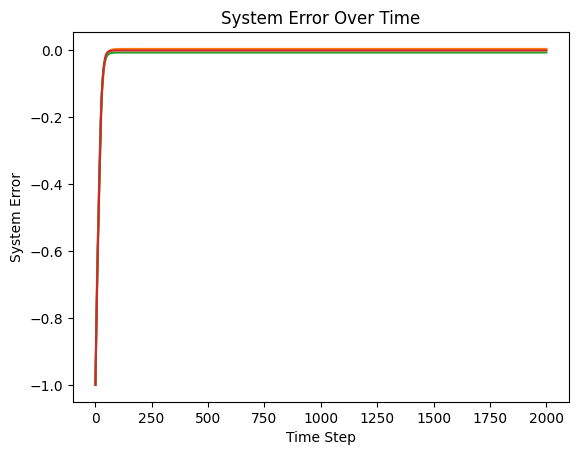

In [ ]:
!mkdir -p checkpoints/checkpoints_linearfirstorder
!pip install wandb
import gym
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os

# Parameter ranges and means
K_range = np.linspace(0.01, 4, 25)
lam1_range = np.linspace(0.01, 2, 25)
lam2_range = np.linspace(0.01, 2, 25)
w1_range = np.linspace(0.01, 1, 25)
w2 = 0.001  # constant

K_mean = (4 + 0.01) / 2
lam1_mean = (2 + 0.01) / 2
lam2_mean = (2 + 0.01) / 2
w1_mean = (1 + 0.01) / 2
for lam2 in lam2_range[21:25]:

    env = LinearFirstOrderEnv(K=K_mean, lam=lam1_mean, lam2=lam2, w1=w1_mean, w2=0.001)

    class SimpleRunner:
        def __init__(self, num_episodes=150, eval_every=40, learn_every=1, noise_variance=0.1, viz=False, wandb_on=True, with_dth=False) -> None:
            self.env = env

            self.num_episodes = num_episodes
            self.max_action = float(self.env.max_action)
            self.K = self.env.K
            self.agent = Agent(self.env.observation_space.shape[0], self.env.action_space.shape[0], max_action=self.max_action, action_scale = self.env.action_scale, action_add = self.env.action_add)

            self.learn_every = learn_every
            self.noise_variance = noise_variance
            self.viz = viz
            self.eval_every = eval_every
            self.wandb_on = wandb_on
            self.avg_window = self.num_episodes//20

            self.init_state = self.env.init_state
            self.targ_state = self.env.targ_state
            self.test_init_state = self.env.test_init_state
            self.test_targ_state = self.env.test_targ_state
            self.new_reward_flag = 1
            self.with_dth = with_dth
            self.lam = self.env.lam
            self.lam2 = self.env.lam2
            self.w1 = self.env.w1
            self.w2 = self.env.w2

            if self.wandb_on:
                wandb.config = {
                    "num_episodes": num_episodes,
                    "learn_every": learn_every,
                    "noise_variance": noise_variance,
                    "eval_every": eval_every,
                    "K": self.K,
                    "max_action": self.max_action,
                    "lambda":self.lam,
                    "lambda2":self.lam2,
                    "w1":self.w1,
                    "w2":self.w2
                }
                wandb.init(project="TD3-errorcontrol-firstorderlinear", entity="rlmpc", config = wandb.config)

        def run(self):
            # print(gymnasium.pprint_registry())
            steps=0
            # print('K*******', self.K)

            # actor_noise = OUNoise(mu=np.zeros(self.env.action_space.shape[0]))
            score_history = [] # score is the sum of rewards of an episode
            best_score = self.env.reward_range[0]
            for episode in range(self.num_episodes):
                observation, info = self.env.reset(init_state=self.init_state, targ_state=self.targ_state)
                # observation, info = self.env.reset()
                # observation, info = self.env.reset(targ_state=self.targ_state)

                # print('info_after_ep_reset', info)

                done = False
                done_ = False
                score = 0
                episode_len = 0
                episode_action = 0
                episode_error = 0.0
                err_actor_episode = 0
                err_critic_episode = 0
                # score_rewards = []
                # while not (done or done_):
                for i in range(int(1000)):
                    actor_noise = np.random.normal(0, self.noise_variance, self.env.action_space.shape)
                    action = self.agent.act(observation) + actor_noise
                    # print('action', action)
                    observation_, reward, done, done_, vars = self.env.step(action)
                    # print(observation, observation_)

                    sys_error = vars['e'] #old state and e calculated wrt the old state
                    sys_error_dot = vars['e_dot'] #old state and e calculated wrt the old state
                    ref_model = vars['ref_model']

                    self.agent.memorize(observation, action, reward, observation_, not (done or done_))
                    observation = observation_

                    if steps % self.learn_every == 0:
                         err_actor, err_critic = self.agent.learn()
                    steps = (steps + 1) % self.learn_every
                    score += reward
                    episode_len += 1
                    episode_action += action
                    episode_error += abs(sys_error)
                    # score_rewards.append(reward)
                    err_actor_episode += err_actor
                    err_critic_episode += err_critic
                    # print('observation, step', observation, episode_len)
                    # print('sys_error, sys_error_dot, action, reward', sys_error, sys_error_dot, action, reward)
                    # print('\n')
                    if self.wandb_on:
                        # wandb.log({'sys_state': sys_state, 'action': action, "step": i, 'reward': reward, 'sys_error': sys_error})
                        wandb.log({'sys_state': observation[0], 'action': action, "step": episode_len, 'reward': reward, 'sys_error': sys_error, 'sys_error_dot': sys_error_dot, 'model': ref_model})
                    # if (done or done_):
                        # print("episode done------------------------------")
                        # break

                score_history.append(score)
                avg_score = np.mean(score_history[-self.avg_window:])
                if avg_score > best_score:
                    best_score = avg_score
                    # best_score_rewards = score_rewards
                    self.best_model_episode = episode

                    if self.new_reward_flag:
                        self.agent.TD.save(f"best_model_"+ str(self.K) + "_targ" + str(int(np.rad2deg(self.targ_state))))
                    else:
                        self.agent.TD.save(f"best_model_"+ "targ" + str(int(np.rad2deg(self.targ_state))))

                train_avg_reward_of_episode = score/episode_len
                train_avg_action_of_episode = episode_action/episode_len
                train_avg_error_of_episode = episode_error/episode_len

                print(f"{episode}, {episode_len}, avg_reward:{train_avg_reward_of_episode}, final_obs_ep:{observation}, final_e_ep:{sys_error}")
                # print("episode done------------------------------")

                if self.wandb_on:
                    wandb.log({"train_episode":episode, "train_score":score, "train_episode_len":episode_len, "train_episode_actor_loss": err_actor_episode, "train_episode_critic_loss":err_critic_episode, "train_avg_reward_of_episode": train_avg_reward_of_episode, "train_avg_action_of_episode": train_avg_action_of_episode, "train_avg_error_of_episode": train_avg_error_of_episode})

                if episode % self.learn_every == 0:
                    # self.agent.TD.save("checkpoints_linearfirstorder" + str(int(self.with_dth)) + "/" + str(episode))
                    self.agent.TD.save("checkpoints/checkpoints_linearfirstorder" + "/" + str(episode))

                if (episode % self.eval_every == 0) and (episode != 0):
                    self.eval(episode)

                # if abs(sys_state - self.targ_state) <= 0.001:
                    # break

            if self.wandb_on:
                wandb.log({"train_best_score": best_score, "train_best_model_episode": self.best_model_episode})

        def eval(self, episode):
            observation, _ = self.env.reset(init_state=self.test_init_state, targ_state=self.test_targ_state)
            done = False
            done_ = False
            score = 0
            episode_error = 0.0
            step = 0

            # while not (done or done_):
            for i in range(int(1000)):
                action = self.agent.act(observation)
                observation_, reward, done, done_, vars = self.env.step(action)
                sys_error = vars['e']
                sys_error_dot = vars['e_dot']
                ref_model = vars['ref_model']

                observation = observation_
                score += reward
                episode_error += sys_error
                step+=1

                if self.wandb_on:
                    wandb.log({"eval_theta_ep_" + str(episode): observation[0], "eval_action_ep_" + str(episode): action, "eval_step" :step, "eval_reward_ep_" + str(episode): reward, "eval_error_ep_" + str(episode): sys_error, "eval_edot_ep_" + str(episode): sys_error_dot, "eval_errormodel_ep_" + str(episode): ref_model})
            print('--------------------------')
            print(f"eval_episode: {episode}, eval_score: {score}")
            print(f"eval_avg_reward: {score/step}, eval_episode_len: {step}, eval_final_obs: {observation}, eval_final_sys_error: {sys_error}, eval_e_dot: {sys_error_dot}")
            print('---------------------------')

            # if self.wandb_on:
                # wandb.log({"eval_episode": episode, "eval_episode_len": step, "eval_score_ep_" + str(episode): score, "eval_episode_error_ep_" + str(episode): episode_error, "eval_avg_reward": score/step})

        def test_after_training(self):
            self.env = env
            self.agent = Agent(self.env.observation_space.shape[0], self.env.action_space.shape[0], max_action=self.max_action)

            if self.new_reward_flag:
                self.agent.TD.load(f"best_model_" + str(self.K) + "_targ" + str(int(np.rad2deg(self.targ_state))))

            observation, _ = self.env.reset(targ_state=self.test_targ_state, init_state=self.test_init_state)
            done = False
            score = 0
            test_step = 0
            episode_error = 0.0
            step_arr = []
            sys_error_arr = []
            test_sys_state = []
            # Run the test episode
            for i in range(2000):
                action = self.agent.act(observation)
                observation_, reward, done, _, vars = self.env.step(action)
                sys_error = vars['e']
                sys_error_dot = vars['e_dot']
                ref_model = vars['ref_model']

                observation = observation_
                score += reward
                test_step += 1
                episode_error += sys_error
                step_arr.append(test_step)
                sys_error_arr.append(sys_error)
                test_sys_state.append(observation[0])
                if self.wandb_on and i > 0:
                    wandb.log({
                        "test_reward": reward,
                        "test_sys_state": observation[0],
                        "test_action": action,
                        "test_step": test_step,
                        "test_sys_error": sys_error,
                        "test_sys_error_dot": sys_error_dot,
                        "test_sys_refmodel": ref_model
                    })
                if self.wandb_on and i == 0:
                    wandb.log({
                        "test_sys_state": self.test_init_state,
                        "test_step": test_step
                    })
            print("this is the test_sys_state",test_sys_state)
            # Calculate performance metrics
            rise_time = self.calculate_rise_time(test_sys_state, step_arr, test_sys_state[-1])
            sse = self.calculate_sse(test_sys_state[-1], self.test_targ_state)

            print('\n')
            print(f"test_avg_reward: {score/test_step}, test_episode_len: {test_step}, test_final_obs: {observation}, test_final_sys_error: {sys_error}")
            print(f"Rise Time: {rise_time}")
            print(f"Steady-State Error (Percentage): {sse}%")
            print('\n')
            self.test_rise_time = rise_time
            self.test_sse_percentage = sse
            if self.wandb_on:
              wandb.log({
                "test_score": score,
                "test_episode_len": test_step,
                "test_error_total": episode_error,
                "test_avg_reward": score/test_step,
                "test_rise_time": rise_time,
                "test_sse_percentage": sse,
                "K": self.K,                   # Log K value
                "lam1": self.lam,               # Log lam1 value
                "lam2": self.lam2,              # Log lam2 value
                "w1": self.w1,                  # Log w1 value
                "w2": self.w2                   # Log w2 value
              })

       # Plot system error over time
            plt.plot(step_arr, sys_error_arr)
            plt.xlabel('Time Step')
            plt.ylabel('System Error')
            plt.title('System Error Over Time')
            print(f"test system state: {observation[0]}")

        def calculate_rise_time(self, test_states, time_steps, final_value):
            required_value = 0.9 * final_value
            closest_value = test_states[0]
            closest_time = time_steps[0]
            initial_difference = abs(closest_value - required_value)

            for i in range(len(test_states)):
                difference = abs(required_value - test_states[i])
                if difference < initial_difference:
                    closest_value = test_states[i]
                    closest_time = time_steps[i]
                    initial_difference = difference

            rise_time = (closest_time - time_steps[0]) * 0.05
            return rise_time

        # def calculate_rise_time(self, test_states, time_steps, final_value):
        #     closest_value = test_states[0]
        #     closest_time = time_steps[0]

        #     for i in range(0, len(test_states)):
        #         difference = abs(0.9*final_value - test_states[i])
        #         if difference <= closest_value:
        #             closest_value = test_states[i]
        #             closest_time = time_steps[i]

        #     rise_time = (closest_time - time_steps[0])*0.05
        #     return rise_time

        def calculate_sse(self, final_value, target_value):
            sse = abs(target_value - final_value)
            sse_percentage = (sse / 1) * 100
            return sse_percentage

    if __name__ == "__main__":
        runner = SimpleRunner(viz = False)
        runner.run()
        runner.test_after_training()
        print(f"Stored Rise Time: {runner.test_rise_time}")
        print(f"Stored Steady-State Error Percentage: {runner.test_sse_percentage}%")

In [ ]:
!mkdir -p checkpoints/checkpoints_linearfirstorder
!pip install wandb
import gym
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os

# Parameter ranges and means
K_range = np.linspace(0.01, 4, 25)
lam1_range = np.linspace(0.01, 2, 25)
lam2_range = np.linspace(0.01, 2, 25)
w1_range = np.linspace(0.01, 1, 25)
w2 = 0.001  # constant

K_mean = (4 + 0.01) / 2
lam1_mean = (2 + 0.01) / 2
lam2_mean = (2 + 0.01) / 2
w1_mean = (1 + 0.01) / 2
for w1 in w1_range:

    env = LinearFirstOrderEnv(K=K_mean, lam=lam1_mean, lam2=lam2_mean, w1=w1, w2=0.001)

    class SimpleRunner:
        def __init__(self, num_episodes=150, eval_every=40, learn_every=1, noise_variance=0.1, viz=False, wandb_on=True, with_dth=False) -> None:
            self.env = env

            self.num_episodes = num_episodes
            self.max_action = float(self.env.max_action)
            self.K = self.env.K
            self.agent = Agent(self.env.observation_space.shape[0], self.env.action_space.shape[0], max_action=self.max_action, action_scale = self.env.action_scale, action_add = self.env.action_add)

            self.learn_every = learn_every
            self.noise_variance = noise_variance
            self.viz = viz
            self.eval_every = eval_every
            self.wandb_on = wandb_on
            self.avg_window = self.num_episodes//20

            self.init_state = self.env.init_state
            self.targ_state = self.env.targ_state
            self.test_init_state = self.env.test_init_state
            self.test_targ_state = self.env.test_targ_state
            self.new_reward_flag = 1
            self.with_dth = with_dth
            self.lam = self.env.lam
            self.lam2 = self.env.lam2
            self.w1 = self.env.w1
            self.w2 = self.env.w2

            if self.wandb_on:
                wandb.config = {
                    "num_episodes": num_episodes,
                    "learn_every": learn_every,
                    "noise_variance": noise_variance,
                    "eval_every": eval_every,
                    "K": self.K,
                    "max_action": self.max_action,
                    "lambda":self.lam,
                    "lambda2":self.lam2,
                    "w1":self.w1,
                    "w2":self.w2
                }
                wandb.init(project="TD3-errorcontrol-firstorderlinear", entity="rlmpc", config = wandb.config)

        def run(self):
            # print(gymnasium.pprint_registry())
            steps=0
            # print('K*******', self.K)

            # actor_noise = OUNoise(mu=np.zeros(self.env.action_space.shape[0]))
            score_history = [] # score is the sum of rewards of an episode
            best_score = self.env.reward_range[0]
            for episode in range(self.num_episodes):
                observation, info = self.env.reset(init_state=self.init_state, targ_state=self.targ_state)
                # observation, info = self.env.reset()
                # observation, info = self.env.reset(targ_state=self.targ_state)

                # print('info_after_ep_reset', info)

                done = False
                done_ = False
                score = 0
                episode_len = 0
                episode_action = 0
                episode_error = 0.0
                err_actor_episode = 0
                err_critic_episode = 0
                # score_rewards = []
                # while not (done or done_):
                for i in range(int(1000)):
                    actor_noise = np.random.normal(0, self.noise_variance, self.env.action_space.shape)
                    action = self.agent.act(observation) + actor_noise
                    # print('action', action)
                    observation_, reward, done, done_, vars = self.env.step(action)
                    # print(observation, observation_)

                    sys_error = vars['e'] #old state and e calculated wrt the old state
                    sys_error_dot = vars['e_dot'] #old state and e calculated wrt the old state
                    ref_model = vars['ref_model']

                    self.agent.memorize(observation, action, reward, observation_, not (done or done_))
                    observation = observation_

                    if steps % self.learn_every == 0:
                         err_actor, err_critic = self.agent.learn()
                    steps = (steps + 1) % self.learn_every
                    score += reward
                    episode_len += 1
                    episode_action += action
                    episode_error += abs(sys_error)
                    # score_rewards.append(reward)
                    err_actor_episode += err_actor
                    err_critic_episode += err_critic
                    # print('observation, step', observation, episode_len)
                    # print('sys_error, sys_error_dot, action, reward', sys_error, sys_error_dot, action, reward)
                    # print('\n')
                    if self.wandb_on:
                        # wandb.log({'sys_state': sys_state, 'action': action, "step": i, 'reward': reward, 'sys_error': sys_error})
                        wandb.log({'sys_state': observation[0], 'action': action, "step": episode_len, 'reward': reward, 'sys_error': sys_error, 'sys_error_dot': sys_error_dot, 'model': ref_model})
                    # if (done or done_):
                        # print("episode done------------------------------")
                        # break

                score_history.append(score)
                avg_score = np.mean(score_history[-self.avg_window:])
                if avg_score > best_score:
                    best_score = avg_score
                    # best_score_rewards = score_rewards
                    self.best_model_episode = episode

                    if self.new_reward_flag:
                        self.agent.TD.save(f"best_model_"+ str(self.K) + "_targ" + str(int(np.rad2deg(self.targ_state))))
                    else:
                        self.agent.TD.save(f"best_model_"+ "targ" + str(int(np.rad2deg(self.targ_state))))

                train_avg_reward_of_episode = score/episode_len
                train_avg_action_of_episode = episode_action/episode_len
                train_avg_error_of_episode = episode_error/episode_len

                print(f"{episode}, {episode_len}, avg_reward:{train_avg_reward_of_episode}, final_obs_ep:{observation}, final_e_ep:{sys_error}")
                # print("episode done------------------------------")

                if self.wandb_on:
                    wandb.log({"train_episode":episode, "train_score":score, "train_episode_len":episode_len, "train_episode_actor_loss": err_actor_episode, "train_episode_critic_loss":err_critic_episode, "train_avg_reward_of_episode": train_avg_reward_of_episode, "train_avg_action_of_episode": train_avg_action_of_episode, "train_avg_error_of_episode": train_avg_error_of_episode})

                if episode % self.learn_every == 0:
                    # self.agent.TD.save("checkpoints_linearfirstorder" + str(int(self.with_dth)) + "/" + str(episode))
                    self.agent.TD.save("checkpoints/checkpoints_linearfirstorder" + "/" + str(episode))

                if (episode % self.eval_every == 0) and (episode != 0):
                    self.eval(episode)

                # if abs(sys_state - self.targ_state) <= 0.001:
                    # break

            if self.wandb_on:
                wandb.log({"train_best_score": best_score, "train_best_model_episode": self.best_model_episode})

        def eval(self, episode):
            observation, _ = self.env.reset(init_state=self.test_init_state, targ_state=self.test_targ_state)
            done = False
            done_ = False
            score = 0
            episode_error = 0.0
            step = 0

            # while not (done or done_):
            for i in range(int(1000)):
                action = self.agent.act(observation)
                observation_, reward, done, done_, vars = self.env.step(action)
                sys_error = vars['e']
                sys_error_dot = vars['e_dot']
                ref_model = vars['ref_model']

                observation = observation_
                score += reward
                episode_error += sys_error
                step+=1

                if self.wandb_on:
                    wandb.log({"eval_theta_ep_" + str(episode): observation[0], "eval_action_ep_" + str(episode): action, "eval_step" :step, "eval_reward_ep_" + str(episode): reward, "eval_error_ep_" + str(episode): sys_error, "eval_edot_ep_" + str(episode): sys_error_dot, "eval_errormodel_ep_" + str(episode): ref_model})
            print('--------------------------')
            print(f"eval_episode: {episode}, eval_score: {score}")
            print(f"eval_avg_reward: {score/step}, eval_episode_len: {step}, eval_final_obs: {observation}, eval_final_sys_error: {sys_error}, eval_e_dot: {sys_error_dot}")
            print('---------------------------')

            # if self.wandb_on:
                # wandb.log({"eval_episode": episode, "eval_episode_len": step, "eval_score_ep_" + str(episode): score, "eval_episode_error_ep_" + str(episode): episode_error, "eval_avg_reward": score/step})

        def test_after_training(self):
            self.env = env
            self.agent = Agent(self.env.observation_space.shape[0], self.env.action_space.shape[0], max_action=self.max_action)

            if self.new_reward_flag:
                self.agent.TD.load(f"best_model_" + str(self.K) + "_targ" + str(int(np.rad2deg(self.targ_state))))

            observation, _ = self.env.reset(targ_state=self.test_targ_state, init_state=self.test_init_state)
            done = False
            score = 0
            test_step = 0
            episode_error = 0.0
            step_arr = []
            sys_error_arr = []
            test_sys_state = []
            # Run the test episode
            for i in range(2000):
                action = self.agent.act(observation)
                observation_, reward, done, _, vars = self.env.step(action)
                sys_error = vars['e']
                sys_error_dot = vars['e_dot']
                ref_model = vars['ref_model']

                observation = observation_
                score += reward
                test_step += 1
                episode_error += sys_error
                step_arr.append(test_step)
                sys_error_arr.append(sys_error)
                test_sys_state.append(observation[0])
                if self.wandb_on and i > 0:
                    wandb.log({
                        "test_reward": reward,
                        "test_sys_state": observation[0],
                        "test_action": action,
                        "test_step": test_step,
                        "test_sys_error": sys_error,
                        "test_sys_error_dot": sys_error_dot,
                        "test_sys_refmodel": ref_model
                    })
                if self.wandb_on and i == 0:
                    wandb.log({
                        "test_sys_state": self.test_init_state,
                        "test_step": test_step
                    })
            print("this is the test_sys_state",test_sys_state)
            # Calculate performance metrics
            rise_time = self.calculate_rise_time(test_sys_state, step_arr, test_sys_state[-1])
            sse = self.calculate_sse(test_sys_state[-1], self.test_targ_state)

            print('\n')
            print(f"test_avg_reward: {score/test_step}, test_episode_len: {test_step}, test_final_obs: {observation}, test_final_sys_error: {sys_error}")
            print(f"Rise Time: {rise_time}")
            print(f"Steady-State Error (Percentage): {sse}%")
            print('\n')
            self.test_rise_time = rise_time
            self.test_sse_percentage = sse
            if self.wandb_on:
              wandb.log({
                "test_score": score,
                "test_episode_len": test_step,
                "test_error_total": episode_error,
                "test_avg_reward": score/test_step,
                "test_rise_time": rise_time,
                "test_sse_percentage": sse,
                "K": self.K,                   # Log K value
                "lam1": self.lam,               # Log lam1 value
                "lam2": self.lam2,              # Log lam2 value
                "w1": self.w1,                  # Log w1 value
                "w2": self.w2                   # Log w2 value
              })

       # Plot system error over time
            plt.plot(step_arr, sys_error_arr)
            plt.xlabel('Time Step')
            plt.ylabel('System Error')
            plt.title('System Error Over Time')
            print(f"test system state: {observation[0]}")

        def calculate_rise_time(self, test_states, time_steps, final_value):
            required_value = 0.9 * final_value
            closest_value = test_states[0]
            closest_time = time_steps[0]
            initial_difference = abs(closest_value - required_value)

            for i in range(len(test_states)):
                difference = abs(required_value - test_states[i])
                if difference < initial_difference:
                    closest_value = test_states[i]
                    closest_time = time_steps[i]
                    initial_difference = difference

            rise_time = (closest_time - time_steps[0]) * 0.05
            return rise_time

        # def calculate_rise_time(self, test_states, time_steps, final_value):
        #     closest_value = test_states[0]
        #     closest_time = time_steps[0]

        #     for i in range(0, len(test_states)):
        #         difference = abs(0.9*final_value - test_states[i])
        #         if difference <= closest_value:
        #             closest_value = test_states[i]
        #             closest_time = time_steps[i]

        #     rise_time = (closest_time - time_steps[0])*0.05
        #     return rise_time

        def calculate_sse(self, final_value, target_value):
            sse = abs(target_value - final_value)
            sse_percentage = (sse / 1) * 100
            return sse_percentage

    if __name__ == "__main__":
        runner = SimpleRunner(viz = False)
        runner.run()
        runner.test_after_training()
        print(f"Stored Rise Time: {runner.test_rise_time}")
        print(f"Stored Steady-State Error Percentage: {runner.test_sse_percentage}%")

K,▁
action,█▃▃▃▃▃▂▃▄▃▃▃▄▂▃▂▂▃▂▃▃▂▄▂▃▄▃▂▃▂▃▃▂▂▂▄▂▃▁▄
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,▁▆██████████████████████████████████████
eval_edot_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,██▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▃██████████████████████████████████████
eval_error_ep_40,▁▄▇█████████████████████████████████████
eval_error_ep_80,▁▆▇█████████████████████████████████████


0, 1000, avg_reward:-1.6042770255445769, final_obs_ep:[ 1.50748167  0.         -2.62466779  0.          2.005     ], final_e_ep:-1.5295896372976285
1, 1000, avg_reward:-1.249118175015722, final_obs_ep:[ 0.59554574  0.         -1.49499822  0.          2.005     ], final_e_ep:-0.578822816961622
2, 1000, avg_reward:-0.2659822250453505, final_obs_ep:[-0.222715    0.          0.26150288  0.          2.005     ], final_e_ep:0.23299789348529626
3, 1000, avg_reward:-0.19005327978948103, final_obs_ep:[-0.24605887  0.          0.79330021  0.          2.005     ], final_e_ep:0.22939022796639433
4, 1000, avg_reward:-0.20394449921723926, final_obs_ep:[-0.16124754  0.          0.30896255  0.          2.005     ], final_e_ep:0.16204435627957978
5, 1000, avg_reward:-0.13574506430062455, final_obs_ep:[0.03744234 0.         0.12522542 0.         2.005     ], final_e_ep:-0.04857306051439532
6, 1000, avg_reward:-0.13819593333665042, final_obs_ep:[ 0.00338569  0.         -0.27712708  0.          2.005     

<ipython-input-11-fee209e78b5e>:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.critic.load_state_dict(torch.load(filename + "_critic.pt", map_location=torch.device(

this is the test_sys_state [0.9641516357660294, 0.9253145009279251, 0.8875020548701287, 0.8505987261235715, 0.8145413817018271, 0.7792724821910263, 0.7447399381349982, 0.7108966365650744, 0.6776999925251708, 0.6451115387388383, 0.6130965585447832, 0.5824784436766044, 0.5538147120723488, 0.5269627135142113, 0.5018057192395113, 0.47823451146751483, 0.4561472760314033, 0.4354490028328555, 0.416050984249132, 0.39787038381601914, 0.3808298122796912, 0.36485695051373535, 0.3498841721465125, 0.3354010103926004, 0.32121459190114804, 0.3073215861087841, 0.29371383113853355, 0.28038368737571434, 0.26732391595130855, 0.25452758502321565, 0.2419881094815474, 0.22969919504125189, 0.21765481474756543, 0.2058492090650738, 0.1942768686352677, 0.182932515405581, 0.1718110722344806, 0.16090765174105975, 0.15023063377328408, 0.1398181826393696, 0.13019004949369065, 0.12163017679844527, 0.11401450783024039, 0.10723898805686659, 0.10121092700966143, 0.09584786858267734, 0.09107644326484635, 0.0868313857197

K,▁
action,▅▁▄▇▆▃▇▅▃▄▆▂▄▇▆▆▅▇▅▄▄▃▄▆▅▄▇▂▆▅▆▅▂▃▄▃▄█▆▅
eval_action_ep_120,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▇▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▆▅▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▆██████████████████████████████████████
eval_error_ep_40,▁▂▇▇████████████████████████████████████
eval_error_ep_80,▁███████████████████████████████████████


0, 1000, avg_reward:-1.3868047273965751, final_obs_ep:[ 0.92223294  0.         -1.80566741  0.          2.005     ], final_e_ep:-0.924645255499429
1, 1000, avg_reward:-0.1812069981199369, final_obs_ep:[ 0.15761852  0.         -0.33229457  0.          2.005     ], final_e_ep:-0.15671441673294384
2, 1000, avg_reward:-0.15588346908477088, final_obs_ep:[ 0.09358411  0.         -0.41589974  0.          2.005     ], final_e_ep:-0.08089927725491092
3, 1000, avg_reward:-0.15054894078214093, final_obs_ep:[0.15308023 0.         0.23572872 0.         2.005     ], final_e_ep:-0.18323608692923654
4, 1000, avg_reward:-0.14336837644638403, final_obs_ep:[0.03252501 0.         0.20948844 0.         2.005     ], final_e_ep:-0.047790417928162174
5, 1000, avg_reward:-0.15153907147683632, final_obs_ep:[-0.01417055  0.         -0.12548045  0.          2.005     ], final_e_ep:0.02272250514607741
6, 1000, avg_reward:-0.13834487929297332, final_obs_ep:[-0.05612035  0.          0.11272483  0.          2.005    

K,▁
action,▅▃▄▂█▁▂▂▅▅▃▃▄▄▅▃▁▃▆▄▆▄▁▅▄▂▆▃▁▃▄▃▄▅▁▂▄▄▃▃
eval_action_ep_120,█▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▇██████████████████████████████████████
eval_error_ep_40,▁▅▇█████████████████████████████████████
eval_error_ep_80,▁▇▇█████████████████████████████████████


0, 1000, avg_reward:-0.29563757541264846, final_obs_ep:[ 0.29478006  0.         -0.48174586  0.          2.005     ], final_e_ep:-0.30085330598431737
1, 1000, avg_reward:-0.19708904119602966, final_obs_ep:[ 0.09920831  0.         -0.1569619   0.          2.005     ], final_e_ep:-0.10153955015407436
2, 1000, avg_reward:-0.15198603979364353, final_obs_ep:[-0.26749588  0.          0.03099839  0.          2.005     ], final_e_ep:0.29557761886064077
3, 1000, avg_reward:-0.19607327995255527, final_obs_ep:[ 0.07009317  0.         -0.10261058  0.          2.005     ], final_e_ep:-0.07220077282137846
4, 1000, avg_reward:-0.1836048842355396, final_obs_ep:[ 0.10717856  0.         -0.12362228  0.          2.005     ], final_e_ep:-0.11225056339124297
5, 1000, avg_reward:-0.14750567446267995, final_obs_ep:[-0.05964964  0.          0.31855402  0.          2.005     ], final_e_ep:0.04859343451154773
6, 1000, avg_reward:-0.14920949618645937, final_obs_ep:[-0.10177648  0.          0.21087598  0.        

K,▁
action,▇▄▃▃▁▅▃▆▄▅▃▄▃▅▂█▅▄▇▅▅▂▃▃▄▆▃▆▆▃▅▂█▄█▄▆▅▅▆
eval_action_ep_120,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,▁▃██████████████████████████████████████
eval_edot_ep_120,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▄▇█████████████████████████████████████
eval_error_ep_40,▁███████████████████████████████████████
eval_error_ep_80,▁▃▆█████████████████████████████████████


0, 1000, avg_reward:-0.42772958782554105, final_obs_ep:[ 0.22066907  0.         -0.4457058   0.          2.005     ], final_e_ep:-0.2204876712480244
1, 1000, avg_reward:-0.1735544791804561, final_obs_ep:[0.03471962 0.         0.14142434 0.         2.005     ], final_e_ep:-0.046447165078423405
2, 1000, avg_reward:-0.17643553434741188, final_obs_ep:[ 0.1069056   0.         -0.85801261  0.          2.005     ], final_e_ep:-0.07113639027262114
3, 1000, avg_reward:-0.1753238502981394, final_obs_ep:[ 0.04688507  0.         -0.20832719  0.          2.005     ], final_e_ep:-0.04053205014598856
4, 1000, avg_reward:-0.16994158651944788, final_obs_ep:[-0.06672229  0.          0.5353037   0.          2.005     ], final_e_ep:0.04440912172365465
5, 1000, avg_reward:-0.1807705689625364, final_obs_ep:[-0.08127401  0.          0.06994637  0.          2.005     ], final_e_ep:0.08644255999052551
6, 1000, avg_reward:-0.16840909075941307, final_obs_ep:[ 0.01114776  0.         -0.11344626  0.          2.005

K,▁
action,▅▄▅▂▂▄▅▅▅▅▁▄▄▁▁▆▄▁▅▃█▁▅▂▅▄▄▁▄▄▄▅▅▃▂▄▄▆▃▃
eval_action_ep_120,█▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▄██████████████████████████████████████
eval_error_ep_40,▁▁▆█████████████████████████████████████
eval_error_ep_80,▁▇██████████████████████████████████████


0, 1000, avg_reward:-0.32511312248572577, final_obs_ep:[ 0.16475404  0.         -0.5797644   0.          2.005     ], final_e_ep:-0.1508928203543684
1, 1000, avg_reward:-0.17406052197944047, final_obs_ep:[-0.00710873  0.          0.31936735  0.          2.005     ], final_e_ep:-0.009846773751624372
2, 1000, avg_reward:-0.20856535810362337, final_obs_ep:[0.01311323 0.         0.21838197 0.         2.005     ], final_e_ep:-0.02671000619399577
3, 1000, avg_reward:-0.19013081265501325, final_obs_ep:[ 0.08956007  0.         -0.40263162  0.          2.005     ], final_e_ep:-0.07716419847795386
4, 1000, avg_reward:-0.5179530405374689, final_obs_ep:[-0.07126575  0.         -0.08231221  0.          2.005     ], final_e_ep:0.08378033680276639
5, 1000, avg_reward:-0.16069862487854805, final_obs_ep:[-0.08815963  0.          0.42167343  0.          2.005     ], final_e_ep:0.07454954931004668
6, 1000, avg_reward:-0.18629832746403824, final_obs_ep:[0.01299962 0.         0.03573177 0.         2.005   

K,▁
action,▂▅▅█▂▃▄▅▅▃▄▁▂▅▆▅▄▃▅▁▄▄▅▇▃▅▆▄▄▆▃▅▆▄█▄▅▆▂▄
eval_action_ep_120,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▃▅█████████████████████████████████████
eval_error_ep_40,▁▃▆▆▇███████████████████████████████████
eval_error_ep_80,▁███████████████████████████████████████


0, 1000, avg_reward:-0.8592379029342311, final_obs_ep:[ 1.28672447  0.         -2.72613076  0.          2.005     ], final_e_ep:-1.2785973114675433
1, 1000, avg_reward:-0.309910882689944, final_obs_ep:[-0.11433981  0.          0.33805123  0.          2.005     ], final_e_ep:0.10829368951303578
2, 1000, avg_reward:-0.19232872595215372, final_obs_ep:[0.02842922 0.         0.29184151 0.         2.005     ], final_e_ep:-0.04781472579873519
3, 1000, avg_reward:-0.3522705133938547, final_obs_ep:[-0.04527044  0.          0.17453243  0.          2.005     ], final_e_ep:0.04061552520315504
4, 1000, avg_reward:-0.18453332967348668, final_obs_ep:[-0.02232389  0.         -0.20647616  0.          2.005     ], final_e_ep:0.03628529642929279
5, 1000, avg_reward:-0.18318102481318743, final_obs_ep:[0.02145822 0.         0.31821709 0.         2.005     ], final_e_ep:-0.04153273503977799
6, 1000, avg_reward:-0.17813913844292778, final_obs_ep:[ 0.02661236  0.         -0.01607165  0.          2.005     ], 

K,▁
action,▄▃▅▇▃▄▇▆▅▇▇▅▇▇█▄▄▁▇▄▃▅▃▆▄▅▄▆▃▆▅▄▅▆▃▄█▂▄▆
eval_action_ep_120,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▆▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,██▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▃██████████████████████████████████████
eval_error_ep_40,▁▄▇▇████████████████████████████████████
eval_error_ep_80,▁▂▆▇████████████████████████████████████


0, 1000, avg_reward:-0.6492313466398372, final_obs_ep:[ 0.08441815  0.         -0.02902253  0.          2.005     ], final_e_ep:-0.09221119722875697
1, 1000, avg_reward:-0.18889500256975397, final_obs_ep:[0.06512511 0.         0.10377368 0.         2.005     ], final_e_ep:-0.07814814484757246
2, 1000, avg_reward:-0.20947628225562848, final_obs_ep:[ 0.00837756  0.         -0.26281412  0.          2.005     ], final_e_ep:0.005293850516425767
3, 1000, avg_reward:-0.19842694141174388, final_obs_ep:[ 0.03074331  0.         -0.32236346  0.          2.005     ], final_e_ep:-0.016254663912971756
4, 1000, avg_reward:-0.20428883863171185, final_obs_ep:[0.00562265 0.         0.18634836 0.         2.005     ], final_e_ep:-0.016604686800047837
5, 1000, avg_reward:-0.19220269883117963, final_obs_ep:[-0.03770689  0.          0.28876954  0.          2.005     ], final_e_ep:0.02586097522685868
6, 1000, avg_reward:-0.18542285423249205, final_obs_ep:[-0.0515729   0.         -0.01167146  0.          2.005

K,▁
action,▃█▆▃▄▆▃▅▇▅▄▆▆▄▁▅▄▅▆▅▃▅▂▄▇▅▄▅▅▄▅▅▃▆▃▅▅▂▄▃
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▂▅▅▆███████████████████████████████████
eval_error_ep_80,▁▃██████████████████████████████████████


0, 1000, avg_reward:-1.797025973287866, final_obs_ep:[ 0.08826216  0.         -0.24312321  0.          2.005     ], final_e_ep:-0.08458571683421279
1, 1000, avg_reward:-0.21878588581517644, final_obs_ep:[-0.0863457   0.          0.35127216  0.          2.005     ], final_e_ep:0.07644578028624757
2, 1000, avg_reward:-0.22861176655548326, final_obs_ep:[0.06115425 0.         0.29063324 0.         2.005     ], final_e_ep:-0.08411882486972955
3, 1000, avg_reward:-0.2208047342050064, final_obs_ep:[ 0.03868945  0.         -0.42666118  0.          2.005     ], final_e_ep:-0.019290239558297964
4, 1000, avg_reward:-0.2032226630567093, final_obs_ep:[-0.04503793  0.          0.53808951  0.          2.005     ], final_e_ep:0.020153876023415444
5, 1000, avg_reward:-0.20663117875671236, final_obs_ep:[-0.04108918  0.          0.31880719  0.          2.005     ], final_e_ep:0.02795090358972007
6, 1000, avg_reward:-0.20483637367051669, final_obs_ep:[ 0.07073932  0.         -0.29662472  0.          2.005

K,▁
action,█▅▄▃▄▃▄▂▅▄▂▂▄▄▃▂▄▄▃▁▂▅▅▃▄▄▃▄▄▅▁▂▃▄▂▅▄▄▄▃
eval_action_ep_120,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
eval_action_ep_80,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▄▆▆████████████████████████████████████
eval_error_ep_80,▁▇██████████████████████████████████████


0, 1000, avg_reward:-0.4167397540934273, final_obs_ep:[ 0.02539572  0.         -0.05559352  0.          2.005     ], final_e_ep:-0.02513591830365959
1, 1000, avg_reward:-0.38734887002048035, final_obs_ep:[0.08481887 0.         0.36978281 0.         2.005     ], final_e_ep:-0.11481856964335282
2, 1000, avg_reward:-0.21326312869235106, final_obs_ep:[-0.09829843  0.         -0.25280074  0.          2.005     ], final_e_ep:0.12329921103024413
3, 1000, avg_reward:-0.21431254113999978, final_obs_ep:[-0.06315488  0.         -0.50637065  0.          2.005     ], final_e_ep:0.09833110237604831
4, 1000, avg_reward:-0.2133788230085164, final_obs_ep:[-0.0332371   0.          0.04151209  0.          2.005     ], final_e_ep:0.034633500401271756
5, 1000, avg_reward:-0.23486164679541044, final_obs_ep:[-0.0423865   0.         -0.29561787  0.          2.005     ], final_e_ep:0.06353697296718724
6, 1000, avg_reward:-0.22172657525341588, final_obs_ep:[0.02145558 0.         0.22416632 0.         2.005     

K,▁
action,▆▃▄▄▁▄▃▄▅▄▆▃▂▄▆▅▃▅▅▅▅▅▄▆▂▃▂▄█▃▃▇▅▅▃▄▄▄▁▂
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,▁▆██████████████████████████████████████
eval_action_ep_80,▁▂▄▇▇███████████████████████████████████
eval_edot_ep_120,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▆██████████████████████████████████████
eval_error_ep_80,▁███████████████████████████████████████


0, 1000, avg_reward:-1.9850636600024256, final_obs_ep:[ 0.64159331  0.         -0.51760753  0.          2.005     ], final_e_ep:-0.6843155736707743
1, 1000, avg_reward:-0.2519474227242606, final_obs_ep:[ 0.05978088  0.         -0.1571263   0.          2.005     ], final_e_ep:-0.05770999397373964
2, 1000, avg_reward:-0.2346936184122059, final_obs_ep:[ 0.01949804  0.         -0.08584675  0.          2.005     ], final_e_ep:-0.016899922272026555
3, 1000, avg_reward:-0.24182059145154902, final_obs_ep:[ 0.05865137  0.         -0.358311    0.          2.005     ], final_e_ep:-0.045274601145841274
4, 1000, avg_reward:-0.257460319226266, final_obs_ep:[ 0.09359075  0.         -0.45987356  0.          2.005     ], final_e_ep:-0.07846299038467179
5, 1000, avg_reward:-0.2361290226541237, final_obs_ep:[-0.0105549   0.          0.31514875  0.          2.005     ], final_e_ep:-0.0057822081712045476
6, 1000, avg_reward:-0.2208983721583765, final_obs_ep:[0.0040179  0.         0.16763635 0.         2.00

K,▁
action,▆▅▃▅▅▄▅▄▅▄▄▆▆▇▇▄▄▄▄▄▅▆▆█▄▁▄▄▆▂▃▆▆▄▅▆▄▃▆▄
eval_action_ep_120,▁███████████████████████████████████████
eval_action_ep_40,▁▆██████████████████████████████████████
eval_action_ep_80,▁███████████████████████████████████████
eval_edot_ep_120,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▃██████████████████████████████████████
eval_error_ep_40,▁▄▅▇████████████████████████████████████
eval_error_ep_80,▁▃▇█████████████████████████████████████


0, 1000, avg_reward:-0.6972698430892492, final_obs_ep:[ 0.11468404  0.         -0.13409296  0.          2.005     ], final_e_ep:-0.12001044157792151
1, 1000, avg_reward:-0.306840546815815, final_obs_ep:[ 0.1554646   0.         -0.20783367  0.          2.005     ], final_e_ep:-0.16123691225905654
2, 1000, avg_reward:-0.2656085894319543, final_obs_ep:[-0.06926908  0.          0.37269701  0.          2.005     ], final_e_ep:0.056275887006842246
3, 1000, avg_reward:-0.22828067346925995, final_obs_ep:[0.05719489 0.         0.0352542  0.         2.005     ], final_e_ep:-0.06552665059431766
4, 1000, avg_reward:-0.23141717522304742, final_obs_ep:[ 0.02897321  0.         -0.23504369  0.          2.005     ], final_e_ep:-0.019139788501459712
5, 1000, avg_reward:-0.2182735618822994, final_obs_ep:[-8.39908042e-04  0.00000000e+00 -1.07173482e-01  0.00000000e+00
  2.00500000e+00], final_e_ep:0.006889227171555313
6, 1000, avg_reward:-0.22183971786672108, final_obs_ep:[ 0.08462023  0.         -0.48675

K,▁
action,▆█▄▆▃▄▇█▆▅▅▆▄▅▂▆▆▇▅▇▆▆▆▆▅█▂▅▅▄▃▃▁▂▃▅▇▃▃▄
eval_action_ep_120,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,▁▇██████████████████████████████████████
eval_action_ep_80,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▂▅█████████████████████████████████████
eval_error_ep_80,▁▃██████████████████████████████████████


0, 1000, avg_reward:-0.31108925729947756, final_obs_ep:[ 0.01674604  0.         -0.24356793  0.          2.005     ], final_e_ep:-0.005076570082686943
1, 1000, avg_reward:-0.2410861817974444, final_obs_ep:[ 0.06190313  0.         -0.09179648  0.          2.005     ], final_e_ep:-0.06369915036684459
2, 1000, avg_reward:-0.2837461143627945, final_obs_ep:[0.00296238 0.         0.04184043 0.         2.005     ], final_e_ep:-0.005617564341530051
3, 1000, avg_reward:-0.23098961667238327, final_obs_ep:[-0.02511956  0.          0.64550179  0.          2.005     ], final_e_ep:-0.007952794596895353
4, 1000, avg_reward:-0.23074371772639124, final_obs_ep:[-0.06584188  0.         -0.04254693  0.          2.005     ], final_e_ep:0.07554235162187384
5, 1000, avg_reward:-0.2356063004027885, final_obs_ep:[ 0.02830296  0.         -0.02887658  0.          2.005     ], final_e_ep:-0.02985177440254766
6, 1000, avg_reward:-0.23505209005360664, final_obs_ep:[-0.03957387  0.         -0.00776543  0.          2

K,▁
action,█▆▃▅▄▄▄▃▄▃▄▂▅▄▂▄▅▄▄▂▄▃▅▃▄▃▄▄▁▅▃▅▄▄▅▃▃▃▄▄
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▂▅█████████████████████████████████████
eval_error_ep_40,▁▇██████████████████████████████████████
eval_error_ep_80,▁▄██████████████████████████████████████


0, 1000, avg_reward:-0.44363691764202423, final_obs_ep:[0.01988784 0.         0.24616371 0.         2.005     ], final_e_ep:-0.0357833064742931
1, 1000, avg_reward:-0.2641383672345072, final_obs_ep:[-0.03829179  0.         -0.06227129  0.          2.005     ], final_e_ep:0.04601873533143391
2, 1000, avg_reward:-0.2414816814776051, final_obs_ep:[ 0.08708424  0.         -0.38861786  0.          2.005     ], final_e_ep:-0.0751912688509665
3, 1000, avg_reward:-0.2595756111288308, final_obs_ep:[0.00562961 0.         0.11944406 0.         2.005     ], final_e_ep:-0.012894484291138068
4, 1000, avg_reward:-0.3262641920564805, final_obs_ep:[-0.03346991  0.         -0.21485107  0.          2.005     ], final_e_ep:0.04913860590121707
5, 1000, avg_reward:-0.2501673736014312, final_obs_ep:[ 0.00570634  0.         -0.33989609  0.          2.005     ], final_e_ep:0.012546225332341145
6, 1000, avg_reward:-0.2528159368047178, final_obs_ep:[-0.00577924  0.          0.32429262  0.          2.005     ], f

K,▁
action,▃▃▅▄▂▅▄▃▆▄▂▂▃▆▃▂▆▃▄▃▁▁▇▄▃▃▂▃▄▅▇▆▂█▂▃▆▅▃▇
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,▁███████████████████████████████████████
eval_edot_ep_120,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁▇██████████████████████████████████████
eval_error_ep_40,▁▇██████████████████████████████████████
eval_error_ep_80,▁▂▄█████████████████████████████████████


0, 1000, avg_reward:-0.7371545708067813, final_obs_ep:[ 0.03245362  0.         -0.06584732  0.          2.005     ], final_e_ep:-0.03241039538733446
1, 1000, avg_reward:-0.2633868055849965, final_obs_ep:[-0.06265904  0.          0.26554406  0.          2.005     ], final_e_ep:0.05488395828289383
2, 1000, avg_reward:-0.3281668329855887, final_obs_ep:[ 0.00815916  0.         -0.31550552  0.          2.005     ], final_e_ep:0.00846469771899478
3, 1000, avg_reward:-0.27318918002727915, final_obs_ep:[0.03017338 0.         0.69245093 0.         2.005     ], final_e_ep:-0.07201547727396178
4, 1000, avg_reward:-0.255126694695467, final_obs_ep:[0.0306605 0.        0.0180121 0.        2.005    ], final_e_ep:-0.03507763357106344
5, 1000, avg_reward:-0.25758631362761536, final_obs_ep:[ 0.00336102  0.         -0.22314718  0.          2.005     ], final_e_ep:0.008665003301787865
6, 1000, avg_reward:-0.26405680983716123, final_obs_ep:[-0.10772529  0.          0.14097561  0.          2.005     ], fina

K,▁
action,▃▃▅▃▃▃▂▆▁▄▅▂▄▄▃▄▆▂▄▆▅▁▃▅▂▄▃▅▃▂█▃▄▄▂▂▂▅▅▃
eval_action_ep_120,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_40,█▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_action_ep_80,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_120,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_40,█▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_edot_ep_80,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_error_ep_120,▁███████████████████████████████████████
eval_error_ep_40,▁▂▆█████████████████████████████████████
eval_error_ep_80,▁▆██████████████████████████████████████


0, 1000, avg_reward:-0.5371326738493393, final_obs_ep:[ 1.07087592e-03  0.00000000e+00 -2.47288044e-02  0.00000000e+00
  2.00500000e+00], final_e_ep:0.0001840114479049887
1, 1000, avg_reward:-0.29623768424622193, final_obs_ep:[ 1.20633701e-03  0.00000000e+00 -2.54041158e-02  0.00000000e+00
  2.00500000e+00], final_e_ep:7.098503082814643e-05
2, 1000, avg_reward:-0.2622612603518436, final_obs_ep:[-0.03163593  0.          0.10975512  0.          2.005     ], final_e_ep:0.029061596403667157
3, 1000, avg_reward:-0.26672569474779967, final_obs_ep:[-0.00242194  0.          0.07649641  0.          2.005     ], final_e_ep:-0.0015591939521827692
4, 1000, avg_reward:-0.2542656744520716, final_obs_ep:[ 0.0166214   0.         -0.21426918  0.          2.005     ], final_e_ep:-0.006566202197216104
5, 1000, avg_reward:-0.2629397317408142, final_obs_ep:[ 0.00447958  0.         -0.18121061  0.          2.005     ], final_e_ep:0.005091356039479601
6, 1000, avg_reward:-0.25230238111805453, final_obs_ep:[-